In [21]:
import pandas as pd
import numpy as np
import os
import yfinance as yf
import itertools
import warnings
import functions as func
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm
from scipy.stats import shapiro

from prophet import Prophet
from prophet.plot import plot, plot_components
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:
DATA_PATH = "nvda_data.json"

if os.path.exists(DATA_PATH):
    
    with open(DATA_PATH) as f:
        nvda_hist = pd.read_json(DATA_PATH)
else:
    nvda = yf.Ticker("NVDA")
    nvda_hist = nvda.history(period="max")

    nvda_hist.to_json(DATA_PATH)

In [4]:
nvda_hist_reset = nvda_hist.reset_index()
nvda_hist_reset = nvda_hist_reset.rename(columns={'index': 'ds', 'Close': 'y'})
nvda_prophet_data = nvda_hist_reset[['ds', 'y']].copy()
nvda_prophet_data['ds'] = pd.to_datetime(nvda_prophet_data['ds'])

print(nvda_prophet_data.head())

                   ds         y
0 1999-01-22 05:00:00  0.376237
1 1999-01-25 05:00:00  0.415653
2 1999-01-26 05:00:00  0.383404
3 1999-01-27 05:00:00  0.382210
4 1999-01-28 05:00:00  0.381015


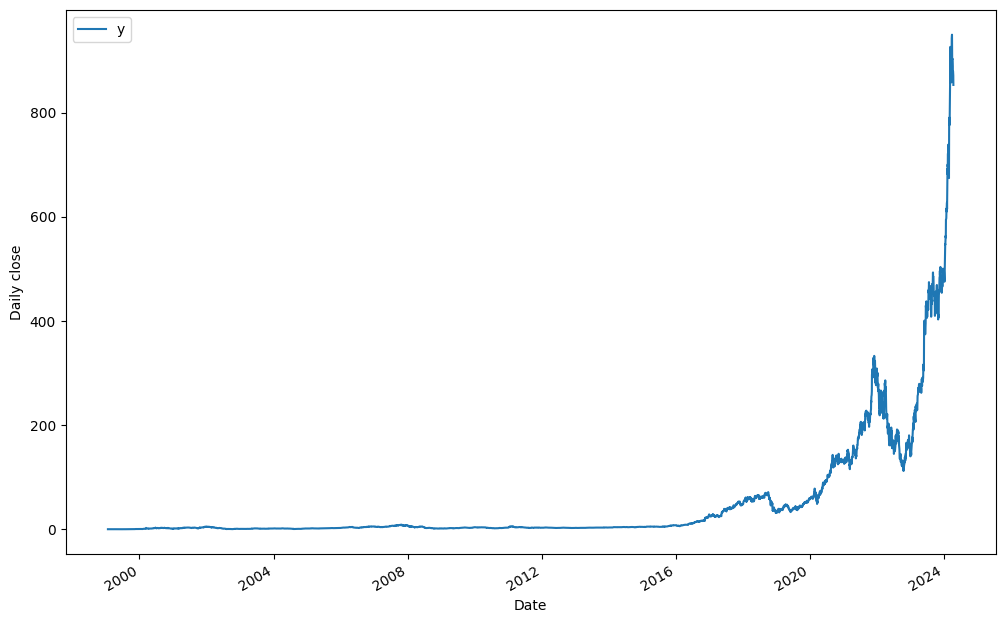

In [5]:
ax = nvda_prophet_data.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Daily close')
ax.set_xlabel('Date')

plt.show()

In [6]:
model = Prophet()
model.fit(nvda_prophet_data) 

13:50:26 - cmdstanpy - INFO - Chain [1] start processing
13:50:28 - cmdstanpy - INFO - Chain [1] done processing


In [7]:
future = model.make_future_dataframe(periods=12, freq='M')
forecast = model.predict(future)   

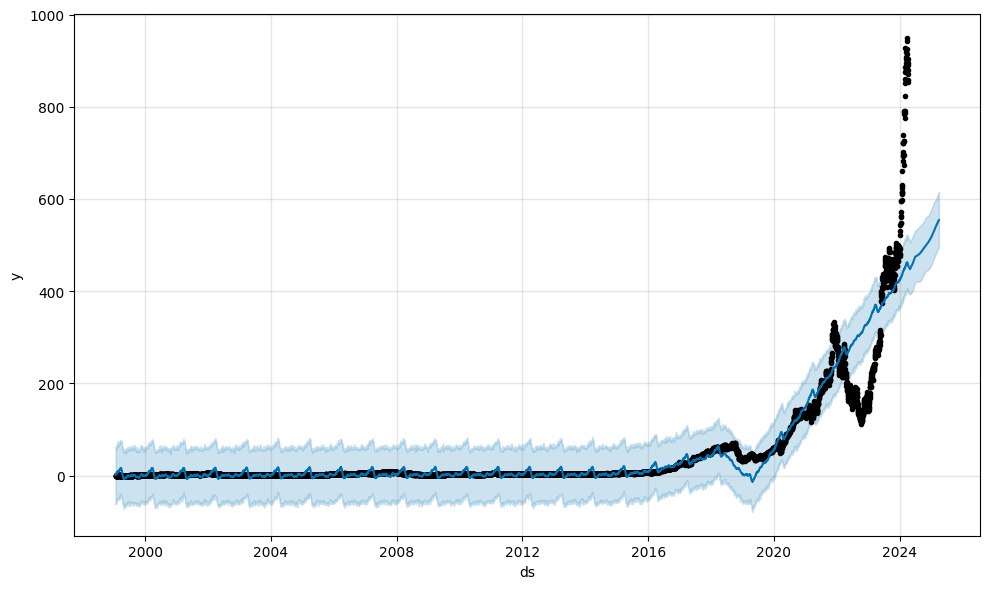

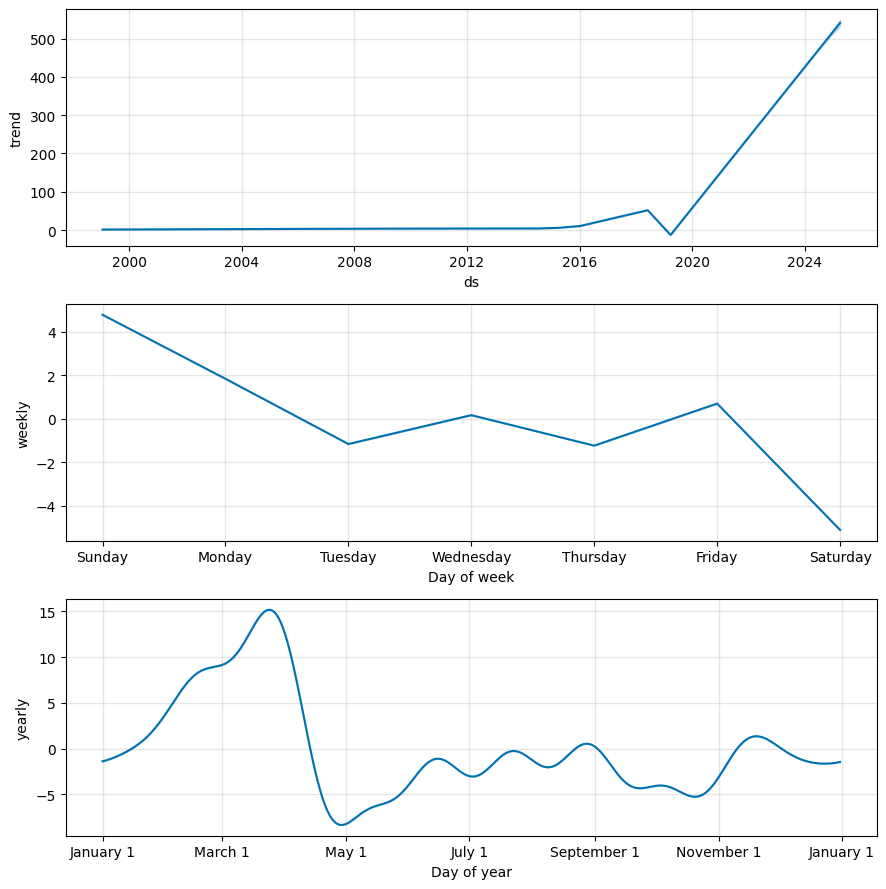

In [8]:
plot(model, forecast)
plot_components(model, forecast) 
plt.show()

In [9]:
nvda_prophet_data

,ds,y
0,1999-01-22 05:00:00,0.376237
1,1999-01-25 05:00:00,0.415653
2,1999-01-26 05:00:00,0.383404
3,1999-01-27 05:00:00,0.382210
4,1999-01-28 05:00:00,0.381015
...,...,...
6339,2024-04-03 04:00:00,889.640015
6340,2024-04-04 04:00:00,859.049988
6341,2024-04-05 04:00:00,880.080017
6342,2024-04-08 04:00:00,871.330017


In [10]:
nvda_prophet_data['ds'] = pd.to_datetime(nvda_prophet_data['ds'])
start_date = pd.Timestamp('2020-01-22 05:00:00')
nvda_prophet_2020 = nvda_prophet_data[nvda_prophet_data['ds'] >= start_date]

In [11]:
model_2020 = Prophet()
model_2020.fit(nvda_prophet_2020) 

13:50:32 - cmdstanpy - INFO - Chain [1] start processing
13:50:33 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
future = model_2020.make_future_dataframe(periods=12, freq='M')
forecast = model_2020.predict(future)   

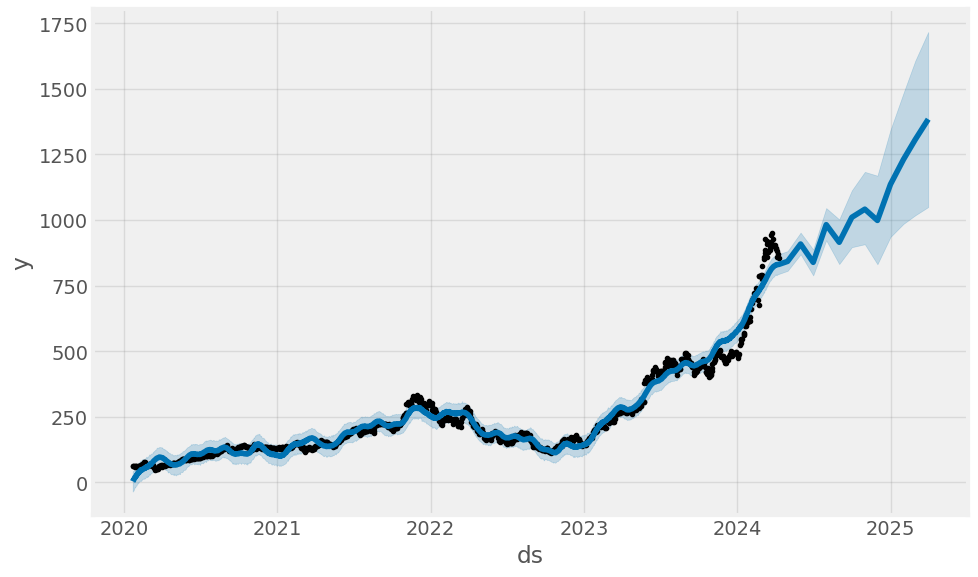

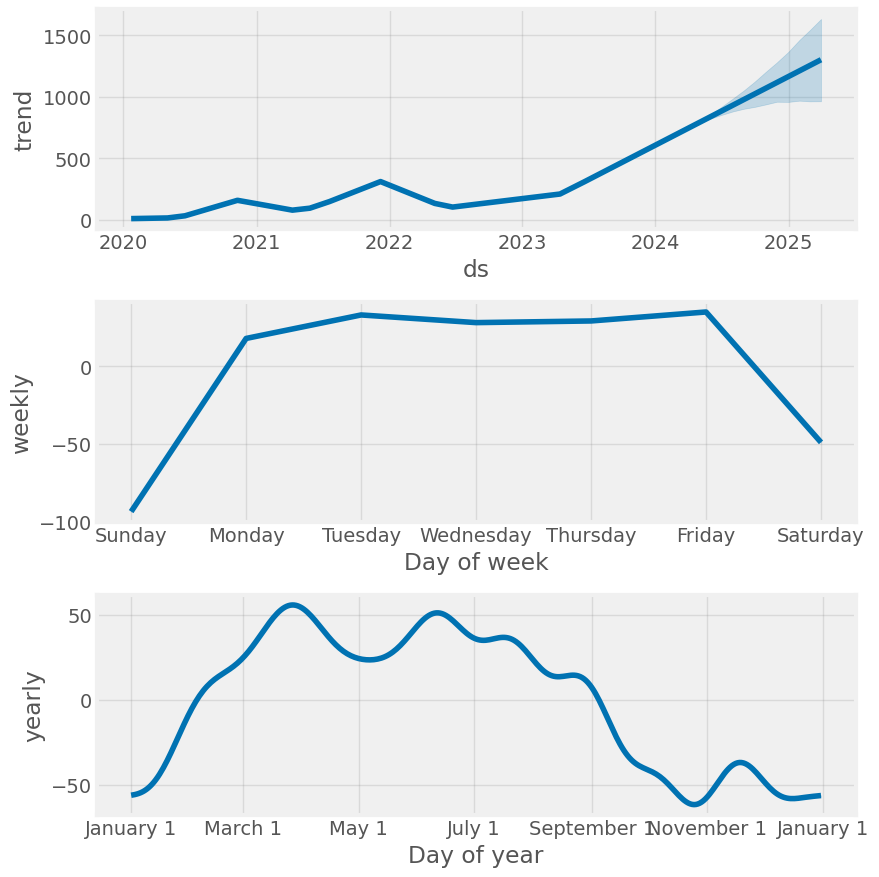

In [20]:
plot(model_2020, forecast)
plot_components(model_2020, forecast) 
plt.show()

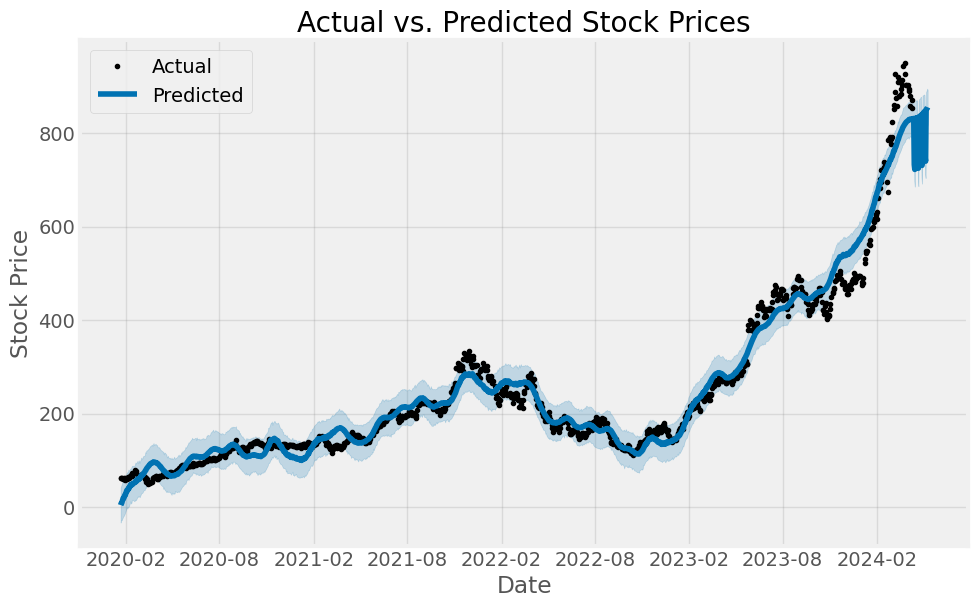

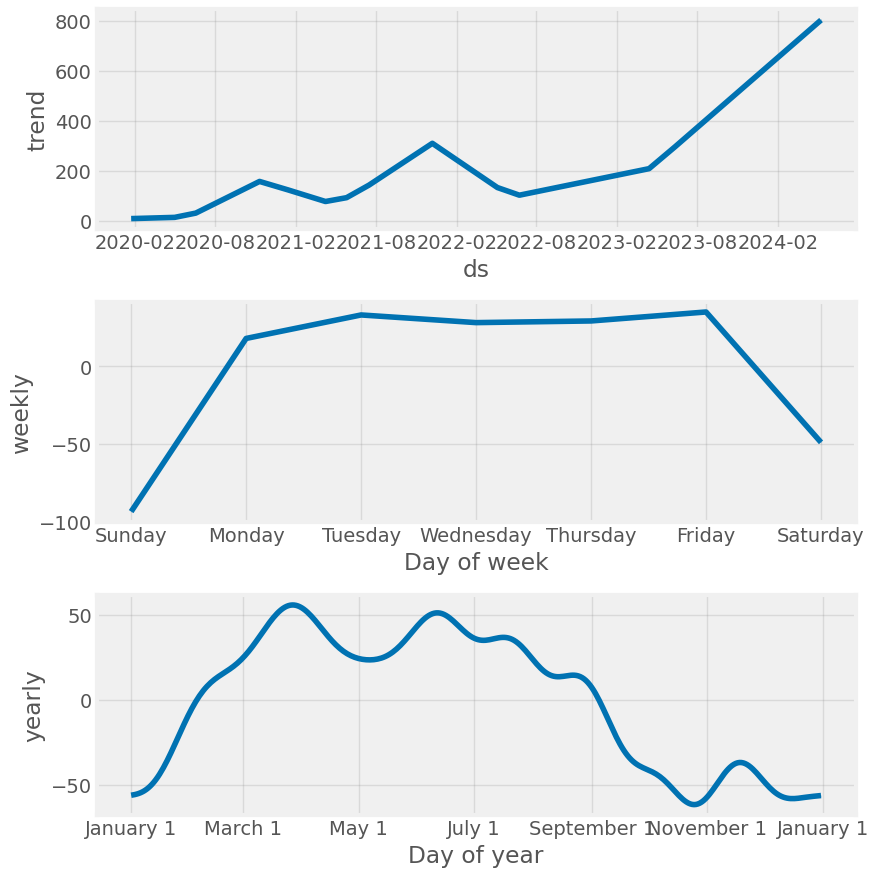

In [25]:
future = model_2020.make_future_dataframe(periods=30, freq='D')

forecast_2020 = model_2020.predict(future)

model_2020.plot(forecast_2020)
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Actual vs. Predicted Stock Prices')
plt.legend(['Actual', 'Predicted'])
plt.show()

model_2020.plot_components(forecast_2020)
plt.show()

15:50:11 - cmdstanpy - INFO - Chain [1] start processing
15:50:11 - cmdstanpy - INFO - Chain [1] done processing


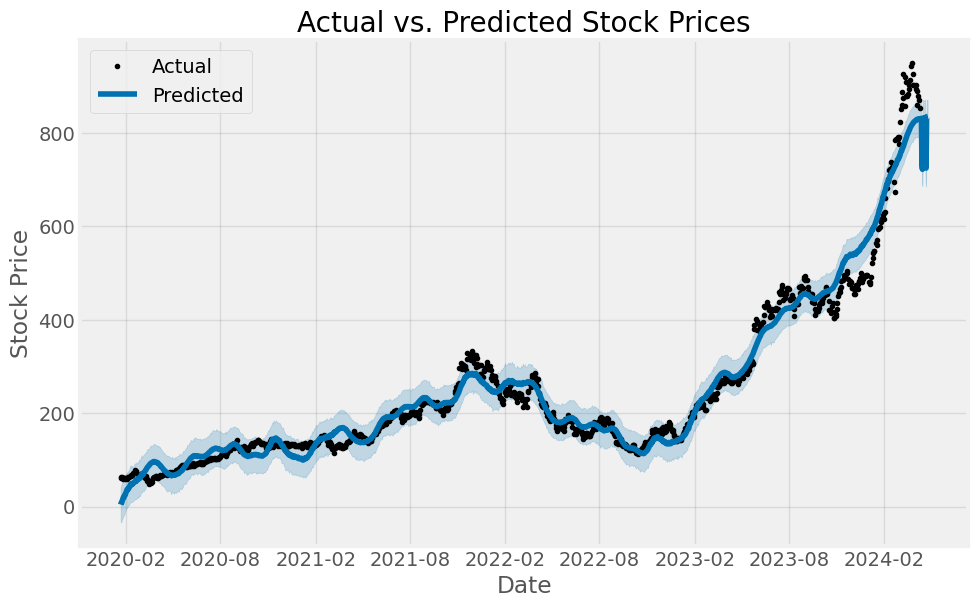

Mean Squared Error (MSE): 863.4583996132975
Root Mean Squared Error (RMSE): 29.384662659511637
Mean Absolute Error (MAE): 21.239831058390994


In [35]:
model = Prophet()
model.fit(nvda_prophet_2020)

future = model.make_future_dataframe(periods=15, freq='D')

forecast = model.predict(future)

model.plot(forecast)
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Actual vs. Predicted Stock Prices')
plt.legend(['Actual', 'Predicted'])
plt.show()

mse = mean_squared_error(nvda_prophet_2020['y'], forecast['yhat'][:-15]) 
rmse = mse ** 0.5
mae = mean_absolute_error(nvda_prophet_2020['y'], forecast['yhat'][:-15]) 

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)

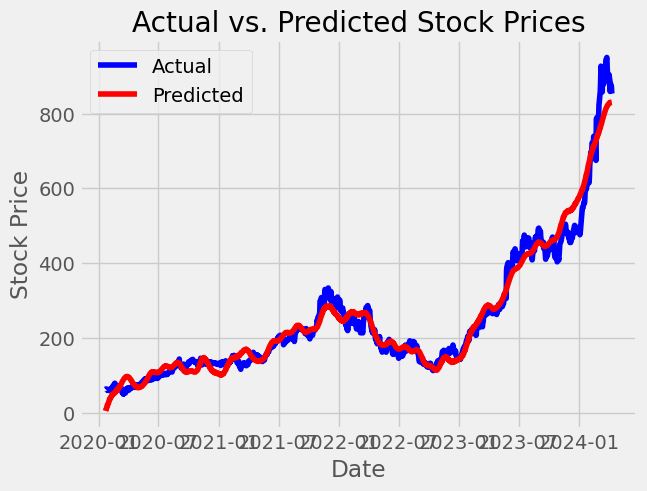

In [32]:
merged_df = pd.merge(nvda_prophet_2020, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds', how='left')
plt.plot(merged_df['ds'], merged_df['y'], label='Actual', color='blue')
plt.plot(merged_df['ds'], merged_df['yhat'], label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Actual vs. Predicted Stock Prices')
plt.legend()
plt.show()

In [33]:
merged_df

,ds,y,yhat,yhat_lower,yhat_upper
0,2020-01-22 05:00:00,62.281185,4.305700,-32.079647,43.414671
1,2020-01-23 05:00:00,62.965981,7.833971,-29.772831,46.567932
2,2020-01-24 05:00:00,62.373329,8.264968,-29.912827,43.730782
3,2020-01-27 05:00:00,59.813454,19.279357,-17.024818,56.408646
4,2020-01-28 05:00:00,61.748302,18.977271,-20.353904,59.087447
...,...,...,...,...,...
1056,2024-04-03 04:00:00,889.640015,827.938641,790.370585,865.480466
1057,2024-04-04 04:00:00,859.049988,829.401517,792.468868,864.093098
1058,2024-04-05 04:00:00,880.080017,829.934754,791.291311,865.730583
1059,2024-04-08 04:00:00,871.330017,830.219833,790.731299,867.973290
